# Diffusion model for clutter denoising

## Initialization

### Imports

In [1]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
#from models.unet import *
from models.DUnet import *
import torch.optim as optim
#from utils.trainer import *
from utils.Dtrainer import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
#from models.diffusion import *
from models.DDiffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

### Define device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialiaze W&B + config

In [3]:
run_name = 'comp1-dualbranch'

In [4]:
wandb.init(
    project="New-Radar-diffusion2",
    name=run_name,
    notes="Regular diffusion. this experiment is our benchmark - we check if changes are performing better or worse",
    config={
        "beta_end": 0.02,
        "beta_start": 1e-4,
        "batch_size": 8,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin


## dataset prep

In [5]:
norm_train_dataset = torch.load("norm_train_dataset_1015.pt", weights_only=False)
norm_val_dataset   = torch.load("norm_val_dataset_1015.pt",   weights_only=False)
norm_train_loader = DataLoader(
    norm_train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers
)

norm_val_loader = DataLoader(
    norm_val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers
)

## train

In [6]:
train_loader = norm_train_loader
val_loader   = norm_val_loader

model        = DualBranchConditionalUNet(time_emb_dim=config.time_emb_dim).to(device)
diffusion    = ConditionalDiffusion(model, scheduler_type=config.scheduler_type,
                                   T=config.noise_steps,
                                   beta_start=config.beta_start,
                                   beta_end=config.beta_end).to(device)
optimizer    = torch.optim.Adam(diffusion.parameters(), lr=config.learning_rate)
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(
                   optimizer,
                   mode='min', factor=0.5,
                   patience=10, threshold=1e-4,
                   cooldown=15, min_lr=1e-6,
                   verbose=True)

best_mse_loss = float('inf')
num_epochs    = config.num_epochs

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# training loop
# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(diffusion, val_loader, device)

    print(f"Epoch {epoch}/{num_epochs}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
    if gen_mse is not None:
        print(f"   → Sampled MSE: {gen_mse:.4f}  PSNR: {gen_psnr:.2f}dB")

    # Scheduler step on validation loss
    scheduler.step(val_loss)

    # Save best MSE
    if gen_mse is not None and gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(diffusion.state_dict(), f"{run_name}_best_mse.pth")
        print("   → Saved new best‑MSE model")

    # Log to W&B
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "sample_mse": gen_mse,
        "sample_psnr": gen_psnr,
        "lr": optimizer.param_groups[0]['lr']
    })

/home/hawk/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/400  Train Loss: 0.9695  Val Loss: 0.9484
   → Sampled MSE: 1123902592.0000  PSNR: -54.21dB
   → Saved new best‑MSE model
Epoch 2/400  Train Loss: 0.9342  Val Loss: 0.9222
   → Sampled MSE: 1066264448.0000  PSNR: -53.98dB
   → Saved new best‑MSE model
Epoch 3/400  Train Loss: 0.9125  Val Loss: 0.9048
   → Sampled MSE: 1039244416.0000  PSNR: -53.87dB
   → Saved new best‑MSE model
Epoch 4/400  Train Loss: 0.8993  Val Loss: 0.8951
   → Sampled MSE: 1029993152.0000  PSNR: -53.83dB
   → Saved new best‑MSE model
Epoch 5/400  Train Loss: 0.8909  Val Loss: 0.8877
   → Sampled MSE: 1006057472.0000  PSNR: -53.73dB
   → Saved new best‑MSE model
Epoch 6/400  Train Loss: 0.8845  Val Loss: 0.8810
   → Sampled MSE: 1002067776.0000  PSNR: -53.71dB
   → Saved new best‑MSE model
Epoch 7/400  Train Loss: 0.8800  Val Loss: 0.8779
   → Sampled MSE: 992512576.0000  PSNR: -53.67dB
   → Saved new best‑MSE model
Epoch 8/400  Train Loss: 0.8762  Val Loss: 0.8738
   → Sampled MSE: 978494336.0000  PSNR: -

KeyboardInterrupt: 

In [6]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)

cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

/home/hawk/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[16, 0, 64, 64] to have 4 channels, but got 0 channels instead

wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run rei4tyrh was previously created and deleted; try a 

In [ ]:
best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []
e_mse_loss = None
e_rd_loss = None
iq_val_loss = None
rd_val_loss = None

for epoch in range(num_epochs):
    #train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    #val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), f"{run_name}.pth")
        print("   --> Best MSE model saved.")

    wandb.log({
        "total train loss": train_loss,
        "total val loss": val_loss,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


Epoch 1/400: Train Loss = 0.0567 | Val Loss = 0.0302
   [Generation Metrics] MSE: 1268.0046 | PSNR: 5.65 dB
   --> Best MSE model saved.
Epoch 2/400: Train Loss = 0.0262 | Val Loss = 0.0233
   [Generation Metrics] MSE: 57.2247 | PSNR: 19.11 dB
   --> Best MSE model saved.
Epoch 3/400: Train Loss = 0.0214 | Val Loss = 0.0196
   [Generation Metrics] MSE: 442.7359 | PSNR: 10.22 dB
Epoch 4/400: Train Loss = 0.0188 | Val Loss = 0.0169
   [Generation Metrics] MSE: 68197.4062 | PSNR: -11.66 dB
Epoch 5/400: Train Loss = 0.0163 | Val Loss = 0.0146
   [Generation Metrics] MSE: 7343.7451 | PSNR: -1.98 dB
Epoch 6/400: Train Loss = 0.0154 | Val Loss = 0.0135
   [Generation Metrics] MSE: 23469.3086 | PSNR: -7.02 dB
Epoch 7/400: Train Loss = 0.0146 | Val Loss = 0.0131
   [Generation Metrics] MSE: 7.6419 | PSNR: 27.85 dB
   --> Best MSE model saved.
Epoch 8/400: Train Loss = 0.0136 | Val Loss = 0.0129
   [Generation Metrics] MSE: 31431.8379 | PSNR: -8.29 dB
Epoch 9/400: Train Loss = 0.0129 | Val Loss 

KeyboardInterrupt: 

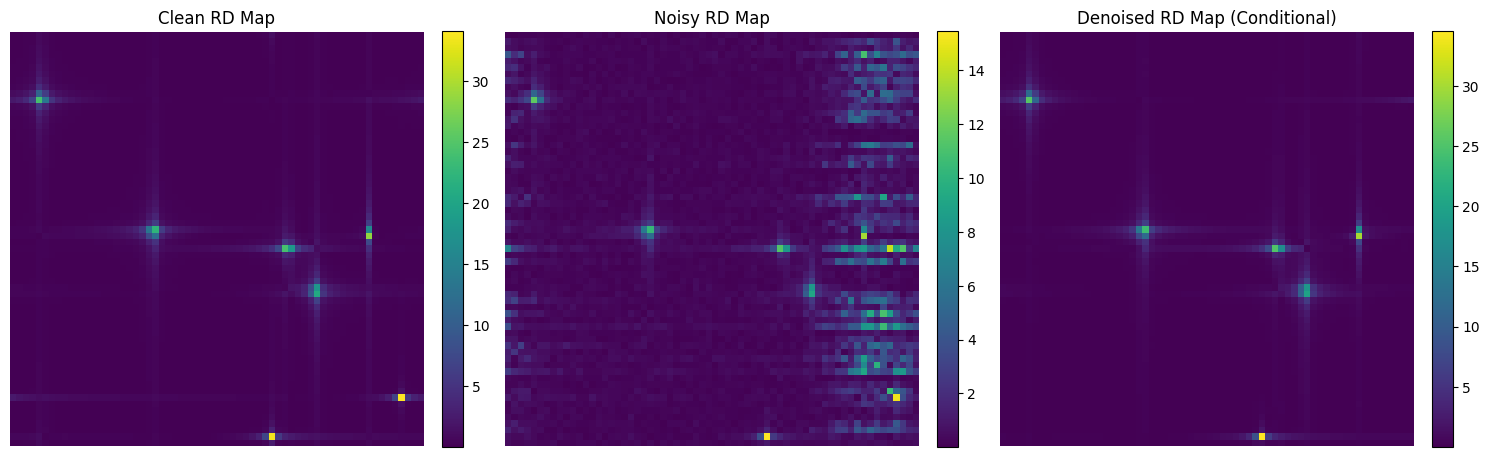

In [ ]:
checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/finalDiffusion/comp1-reg_diff_snr10_cnr15.pth"
run_inference(cond_diffusion , norm_val_dataset, checkpoint_path, device)